# Descriptive analysis of impact of COVID-19 on Crime


In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1716504187234_0002,pyspark,busy,Link,Link,
2,application_1716504187234_0004,pyspark,busy,Link,Link,


In [2]:
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("seaborn==0.11.2", "https://pypi.org/simple")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1716504187234_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9d/ea/6d76df31432a0e6fdf81681a895f009a4bb47b3c39036db3e1b528191d52/pyparsing-3.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/57/56b9bcc3c9c6a792fcbaf139543cee77261f3651ca9da0c93f5c1221264b/python_dateutil-2.9.0.post0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f9/77/e3046bf19720b22e3e0b7c12e28f6f2c0c18a213fb91a56cea640862270f/kiwisolver-1.4.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-a

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import year, month
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
crimes = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace", True) \
    .option("header", "true") \
    .csv("s3://hvpachisia-chicago-crime/data_after_eda/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
covid = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("s3://hvpachisia-chicago-crime/raw_data/COVID-19_Daily_Cases__Deaths__and_Hospitalizations_20240522.csv",inferSchema=True, header=True )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Creating summarized daily total counts of the daily crime data by crime type

In [6]:
crimes.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- community_area: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- community_name: string (nullable = true)
 |-- Birth Rate: string (nullable = true)
 |-- Assault (Homicide): string (nullable = true)
 |-- Below Poverty Level: string (nullable = true)

In [7]:
daily_crimes = crimes.withColumn("only_date", F.to_date(col("Date")))
daily_crime_count = daily_crimes.groupBy("Primary Type", "only_date").count().orderBy("only_date")
daily_crime_count.show(truncate = False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+----------+-----+
|Primary Type              |only_date |count|
+--------------------------+----------+-----+
|CRIM SEXUAL ASSAULT       |2001-01-01|29   |
|DECEPTIVE PRACTICE        |2001-01-01|35   |
|OTHER OFFENSE             |2001-01-01|6    |
|HOMICIDE                  |2001-01-01|2    |
|CRIMINAL SEXUAL ASSAULT   |2001-01-01|4    |
|SEX OFFENSE               |2001-01-01|56   |
|OFFENSE INVOLVING CHILDREN|2001-01-01|80   |
|BATTERY                   |2001-01-01|2    |
|MOTOR VEHICLE THEFT       |2001-01-01|4    |
|THEFT                     |2001-01-01|145  |
|THEFT                     |2001-01-02|10   |
|OTHER OFFENSE             |2001-01-02|1    |
|CRIMINAL TRESPASS         |2001-01-02|2    |
|DECEPTIVE PRACTICE        |2001-01-02|2    |
|MOTOR VEHICLE THEFT       |2001-01-02|2    |
|CRIMINAL TRESPASS         |2001-01-03|4    |
|THEFT                     |2001-01-03|5    |
|BATTERY                   |2001-01-03|2    |
|SEX OFFENSE               |2001-0

Joining daily total covid cases and death data with daily chicago crimes data starting Jan 2020.

In [8]:
covid = covid.withColumnRenamed("Date", "date")
covid = covid.withColumnRenamed("Cases - Total", "daily_cases")
covid = covid.withColumnRenamed("Deaths - Total", "daily_deaths")

covid = covid.withColumn("date", F.to_date(F.col("date"), "MM/dd/yyyy"))

covid = covid.select(["date", "daily_cases", "daily_deaths"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
filtered_crimes = crimes.withColumn("only_date", F.to_date(col("Date")))
filtered_crimes = filtered_crimes.filter(F.col("only_date") >= "2020-01-01")

crime_covid = filtered_crimes.join(covid, filtered_crimes.only_date == covid.date, how="left")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Performing a thorough analysis on how Covid-19 has impacted various types of crimes
compared to previous years.

Keeping only crimes from 3 years before Jan 2020 till present (Jan 2017 onwards) to map a before and after for the impact of COVID on crimes

In [10]:
filtered_crimes = crimes.withColumn("only_date", F.to_date(col("Date")))
filtered_crimes = filtered_crimes.filter(F.col("only_date") >= "2017-01-01")

crime_covid = filtered_crimes.join(covid, filtered_crimes.only_date == covid.date, how="left")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Monthly Trends of different crime types:

Analyzing the monthly trends of different crime types before and after the onset of Covid-19 through visuals. 

In [11]:
import pandas as pd
monthly_trends = (
    crime_covid.groupBy("Month", "Year", "Primary Type")
    .count()
    .withColumnRenamed("count", "Crime Count")
    .orderBy("Year", "Month", "Primary Type")
    .toPandas()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

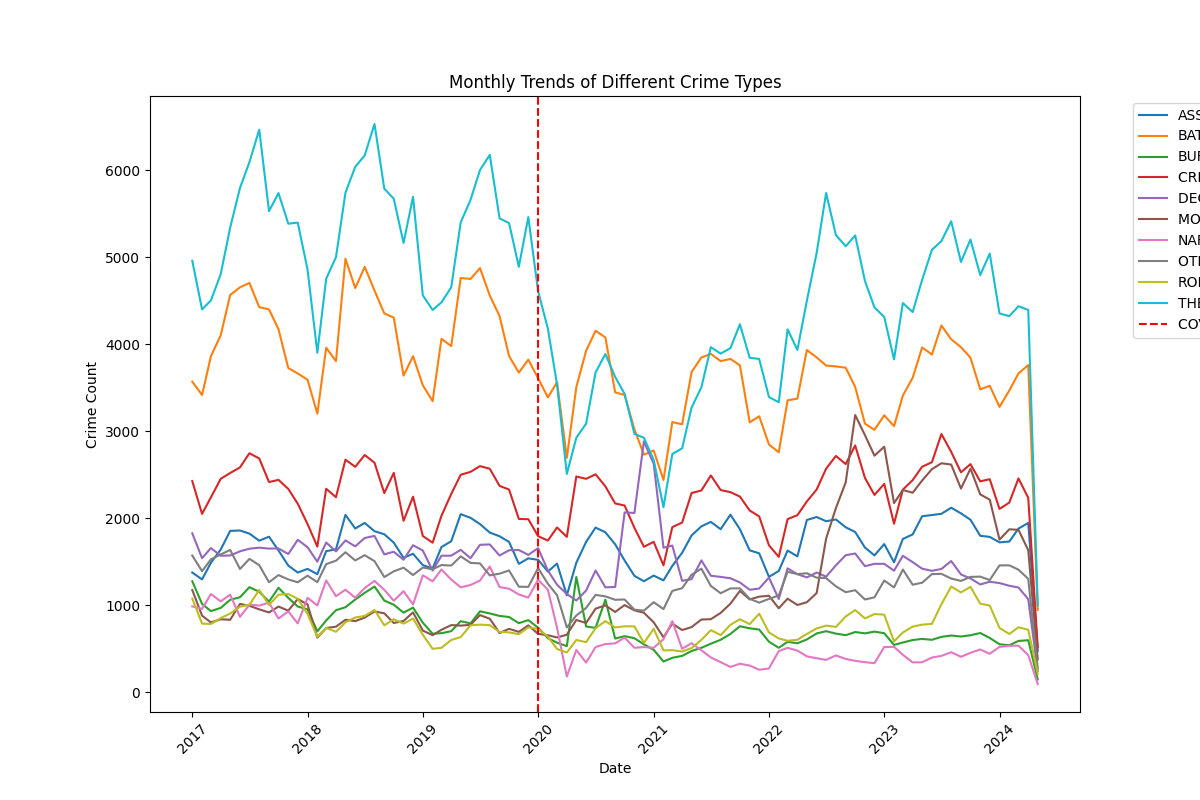

In [12]:
import seaborn as sns
monthly_trends['Date'] = pd.to_datetime(monthly_trends[['Year', 'Month']].assign(DAY=1))
cutoff_date = pd.to_datetime('2020-01-01')

top_10_crimes = monthly_trends.groupby('Primary Type')['Crime Count'].sum().nlargest(10).index
filtered_trends = monthly_trends[monthly_trends['Primary Type'].isin(top_10_crimes)]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Crime Count', hue='Primary Type', data=filtered_trends)
plt.axvline(x=cutoff_date, color='red', linestyle='--', label='COVID-19 ONSET')

plt.title('Monthly Trends of Different Crime Types')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
%matplot plt

We can see a clear effect of COVID-19 on monthly trends in the 10 top crime types (by count) in Chicago. All crimes in general plummet initially. We see a clear fall in 'Theft' as the largest crime type upon the onset of COVID-19 as people would be in lockdown. As time goes on, it rises again and by 2022 is getting back to the levels of pre-COVID times. Interestingly, narcotics also sees a rapid fall on the set of the pandemic due to the lockdown and doesn't seem to have recovered to pre-Covid levels. Battery, as expected, falls initially but then see a quick jump back up to its pre-Covid levels. Interestingly, criminal damage follows pretty much the same pattern before and after COVID. 

### Location-based analysis
A related question to analyze is based on the location of the crime due to lockdown. You would assume that crimes during the pandemic period would skew towards locations like 'Apartments' since people would be confined to their homes. Analyzing whether this holds true below. 

Filtering for locations that should be home-based: residence, house, apartment. 

In [13]:
home_keywords = ['RESIDENCE', 'HOUSE', 'APARTMENT']
home_crimes = crime_covid.filter(col('Location Description').rlike('|'.join(home_keywords)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
monthly_trends = (
    home_crimes.groupBy("Month", "Year", "Location Description")
    .count()
    .withColumnRenamed("count", "Crime Count")
    .orderBy("Year", "Month", "Location Description")
    .toPandas()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

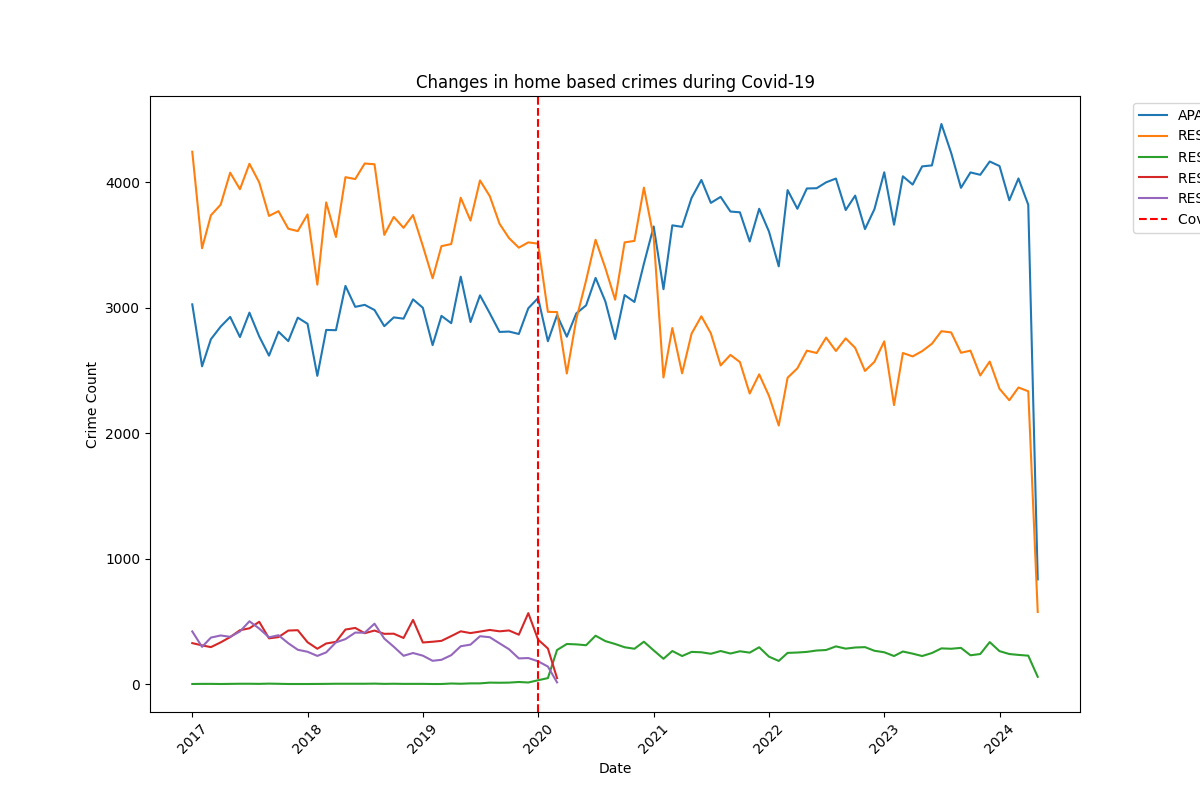

In [15]:
monthly_trends['Date'] = pd.to_datetime(monthly_trends[['Year', 'Month']].assign(DAY=1))

top_5_locations = monthly_trends.groupby('Location Description')['Crime Count'].sum().nlargest(5).index
filtered_trends = monthly_trends[monthly_trends['Location Description'].isin(top_5_locations)]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Crime Count', hue='Location Description', data=filtered_trends)

plt.axvline(x=cutoff_date, color='red', linestyle='--', label='Covid-19 Onset')

plt.title('Changes in home based crimes during Covid-19')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
%matplot plt

Of the top 5 home based keywords, we do see a spike in crimes taking place in 'Apartment' following the onset of COVID-19. Crimes at 'Residence' see a small increase at the end of 2020 but remain relatively the same. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

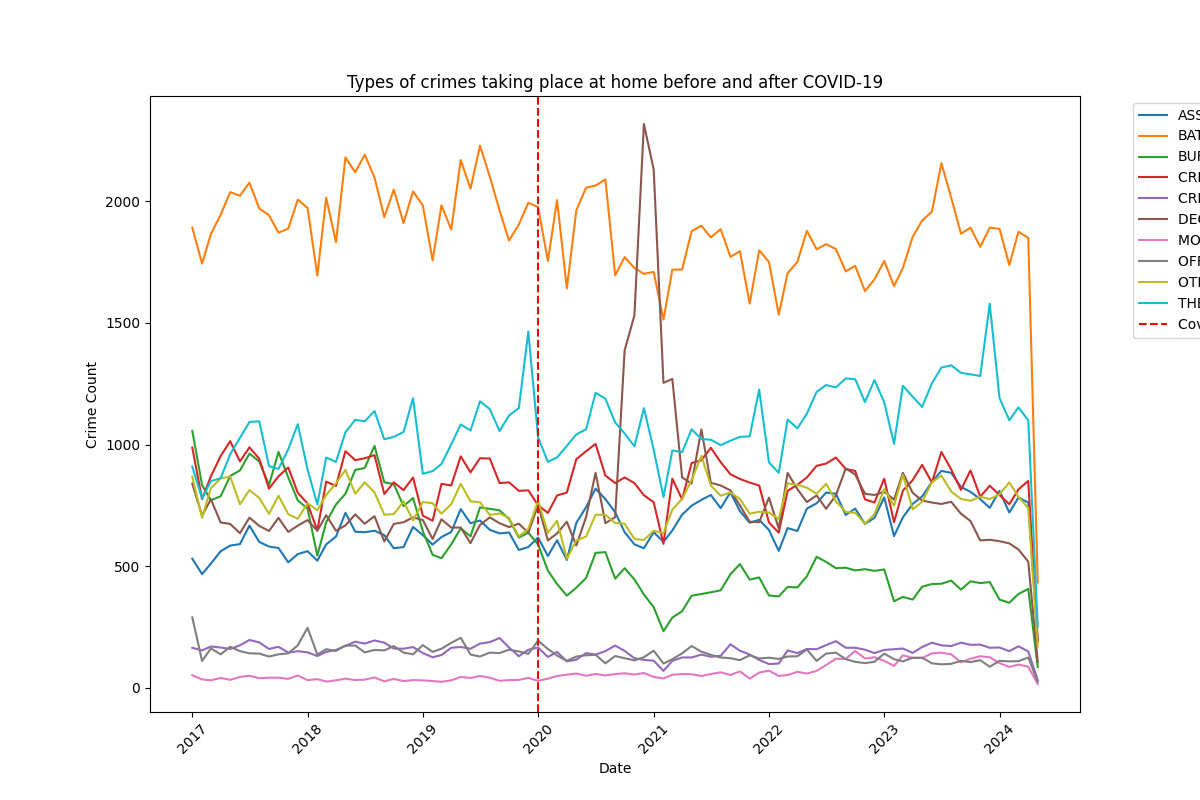

In [16]:
monthly_trends = (
    home_crimes.groupBy("Month", "Year", "Primary Type")
    .count()
    .withColumnRenamed("count", "Crime Count")
    .orderBy("Year", "Month", "Primary Type")
    .toPandas()
)

monthly_trends['Date'] = pd.to_datetime(monthly_trends[['Year', 'Month']].assign(DAY=1))

top_10_types = monthly_trends.groupby('Primary Type')['Crime Count'].sum().nlargest(10).index
filtered_trends = monthly_trends[monthly_trends['Primary Type'].isin(top_10_types)]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Crime Count', hue='Primary Type', data=filtered_trends)

plt.axvline(x=cutoff_date, color='red', linestyle='--', label='Covid-19 Onset')

plt.title('Types of crimes taking place at home before and after COVID-19')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
%matplot plt

Here, we can see for crimes reported from residences or apartments, burglaries do go down following the onset of COVID-19, battery remains very high with theft decreasing. Deceptive practice sees a massive spike in 2021. Criminal damage reported crimes at home do seem to increase as well following the onset of COVID-19. 

### Changes in total crime rates before and after the pandemic:

Comparing the overall crime rates before and during the pandemic.
Calculate and visualize the percentage change in crime rates.

In [17]:
cutoff_date = '2020-01-01'

# Create a column indicating whether the date is before or after the cutoff
crime_covid = crime_covid.withColumn("Before_Pandemic", F.when(col("only_date") < cutoff_date, 1).otherwise(0))

# Calculate overall crime rates before and after the pandemic
total_crime_counts = (
    crime_covid
    .groupBy("Before_Pandemic")
    .agg(F.count("*").alias("Total_Crime"))
)

# Calculate the percentage of crimes before and after the pandemic
percentage_crime = (
    total_crime_counts
    .withColumn("Percentage_Crime", (col("Total_Crime") / F.sum("Total_Crime").over(Window.partitionBy())) * 100)
)

percentage_crime.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-----------+------------------+
|Before_Pandemic|Total_Crime|  Percentage_Crime|
+---------------+-----------+------------------+
|              1|     799631|44.268684331010185|
|              0|    1006682| 55.73131566898981|
+---------------+-----------+------------------+

We see an increase in crime (4.45% increase) after the pandemic hit (Jan 2020-Oct 2023) as compared to before the pandemic starting in Jan 2017. 

### Community level analysis: Were crime-prone communities impacted more by COVID-19?
Did the communities that had the highest covid cases also have the most crime? This can help explain the correlations we often see that neighborhoods with more crime would have lower access to healthcare, hence more COVID cases. 

In [18]:
# Filter crimes from January 2020 onwards since that is when COVID cases started
filtered_crimes = crimes.withColumn("only_date", F.to_date(col("Date")))
filtered_crimes = filtered_crimes.filter(F.col("only_date") >= "2020-01-01")

# Left join the two DataFrames on the 'date' column
crime_covid_2020 = filtered_crimes.join(covid, filtered_crimes.only_date == covid.date, how="left")
crime_covid_2020 = crime_covid.withColumn("daily_cases", col("daily_cases").cast("integer"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

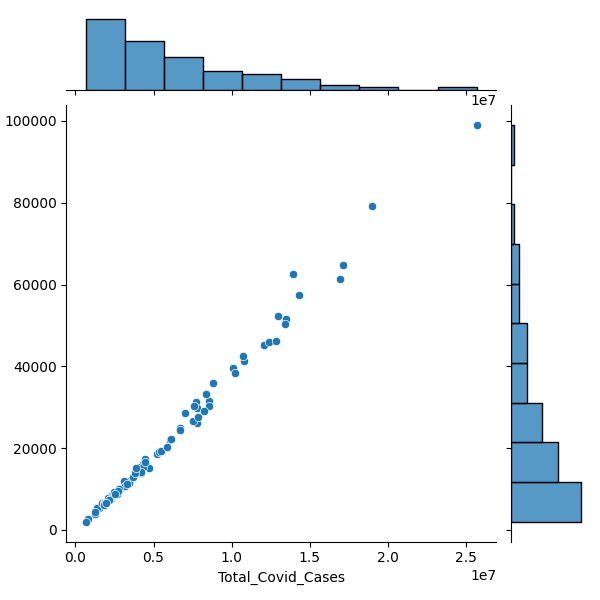

In [19]:
community_data = (
    crime_covid_2020
    .groupBy("community_name")
    .agg(
        F.sum("daily_cases").cast("integer").alias("Total_Covid_Cases"),
        F.count("*").cast("integer").alias("Total_Crime_Count")
    )
)

community_data_pd = community_data.toPandas()

# Calculate the correlation coefficient using Pandas
correlation_coefficient = community_data_pd["Total_Covid_Cases"].corr(community_data_pd["Total_Crime_Count"])

# Visualize the relationship with a scatter plot
sns.scatterplot(x='Total_Covid_Cases', y='Total_Crime_Count', data=community_data_pd)
plt.title(f'Covid-Crime Correlation (Correlation Coefficient: {correlation_coefficient:.2f})')
plt.xlabel('Total COVID-19 Cases')
plt.ylabel('Total Crime Counts')
plt.show()
%matplot plt
sns.jointplot(x='Total_Covid_Cases', y='Total_Crime_Count', data=community_data_pd, kind='scatter')
plt.show()
%matplot plt

We see a very clear relationship between number of crimes and COVID cases in each neighborhood. If number of crimes increases, the number of cases seem to increase as well. 

In [20]:
# Order the communities by total COVID-19 cases in descending order
top_communities_covid = (
    community_data
    .orderBy("Total_Covid_Cases", ascending=False)
    .limit(5)
)
top_communities_covid.show()

top_communities_crime = (
    community_data
    .orderBy("Total_Crime_Count", ascending=False)
    .limit(5)
)
top_communities_crime.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-----------------+-----------------+
| community_name|Total_Covid_Cases|Total_Crime_Count|
+---------------+-----------------+-----------------+
|         Austin|         25684368|            98967|
|Near North Side|         18963911|            79163|
| Near West Side|         17108448|            64671|
|    South Shore|         16943242|            61300|
| North Lawndale|         14320883|            57469|
+---------------+-----------------+-----------------+

+---------------+-----------------+-----------------+
| community_name|Total_Covid_Cases|Total_Crime_Count|
+---------------+-----------------+-----------------+
|         Austin|         25684368|            98967|
|Near North Side|         18963911|            79163|
| Near West Side|         17108448|            64671|
|       The Loop|         13954360|            62671|
|    South Shore|         16943242|            61300|
+---------------+-----------------+-----------------+

Here we can clearly see that the communities with the most cases also had the highest crime count, showcasing the relationship discussed. 

**I do a similar metric for the number of deaths v. crimes below**

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

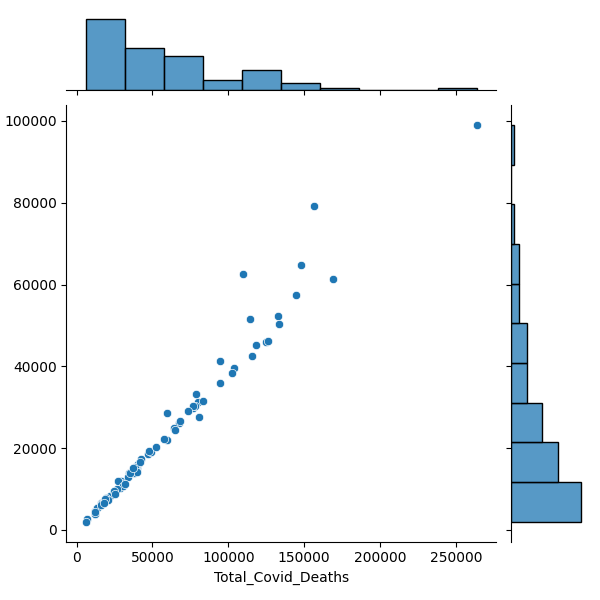

In [21]:
community_data = (
    crime_covid_2020
    .groupBy("community_name")
    .agg(
        F.sum("daily_deaths").cast("integer").alias("Total_Covid_Deaths"),
        F.count("*").cast("integer").alias("Total_Crime_Count")
    )
)
community_data_pd = community_data.toPandas()

correlation_coefficient = community_data_pd["Total_Covid_Deaths"].corr(community_data_pd["Total_Crime_Count"])

sns.scatterplot(x='Total_Covid_Deaths', y='Total_Crime_Count', data=community_data_pd)
plt.title(f'Covid Deaths-Crime Correlation (Correlation Coefficient: {correlation_coefficient:.2f})')
plt.xlabel('Total COVID-19 Deaths')
plt.ylabel('Total Crime Counts')
plt.show()
%matplot plt
sns.jointplot(x='Total_Covid_Deaths', y='Total_Crime_Count', data=community_data_pd, kind='scatter')
%matplot plt

In [22]:
# Order the communities by total COVID-19 cases in descending order
top_communities_covid_deaths = (
    community_data
    .orderBy("Total_Covid_Deaths", ascending=False)
    .limit(5)
)
top_communities_covid_deaths.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+-----------------+
| community_name|Total_Covid_Deaths|Total_Crime_Count|
+---------------+------------------+-----------------+
|         Austin|            263604|            98967|
|    South Shore|            168804|            61300|
|Near North Side|            156372|            79163|
| Near West Side|            147627|            64671|
| North Lawndale|            144346|            57469|
+---------------+------------------+-----------------+

Similar to COVID cases, we find that COVID deaths also have a very high positive correlation (0.99) with total crime count, highlighting the fact that the pandemic hit the communities where crime was the most prevelant, with poorer access to healthcare. 

By doing the monthly trends by primary type of crime, analysing the location-based crime spikes (home v. outside), overall crime rates before and after COVID-19, and analyzing the nature of the relationship between crime and COVID cases/deaths in specific community, I have showcased how COVID-19 impacted various types of crimes compared to previous years. 